Introduce project

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

explain what is being imported. two stations are 5 mi apart

In [2]:
# import NOAA data
dfnoaa = pd.read_csv('NV2024noaa.csv')

# import USGS data
dfusgs = pd.read_csv('NV2024usgs.csv')

data cleaning for NOAA df

In [3]:
dfnoaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  366 non-null    object 
 1   NAME     366 non-null    object 
 2   DATE     366 non-null    object 
 3   PRCP     366 non-null    float64
 4   TMAX     366 non-null    int64  
 5   TMIN     366 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 17.3+ KB


In [4]:
# make a copy for the cleaned df so the original is untouched
cleandfnoaa = dfnoaa.copy()

# we are looking at one station only, so 'STATION' and 'NAME' columns are redundant
cleandfnoaa = cleandfnoaa.drop(columns=['STATION', 'NAME'])

# set the data type of the 'DATE' column to datetime
cleandfnoaa.DATE = pd.to_datetime(cleandfnoaa.DATE)

# rename columns
cleandfnoaa = cleandfnoaa.rename(columns= {'DATE':'date', 'PRCP':'prcp',
                                          'TMAX':'tmax', 'TMIN':'tmin'})

# verify that df is cleaned
cleandfnoaa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   prcp    366 non-null    float64       
 2   tmax    366 non-null    int64         
 3   tmin    366 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.6 KB


data cleaning for USGS data

In [5]:
dfusgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       362 non-null    object 
 1   site_no        362 non-null    int64  
 2   72019_Mean     362 non-null    float64
 3   72019_Mean_cd  362 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.4+ KB


In [6]:
# make a copy for the cleaned df so the original is untouched
cleandfusgs = dfusgs.copy()

# rename columns for ease of use
cleandfusgs = cleandfusgs.rename(columns= {'datetime':'date', '72019_Mean': 'water_level'})

# set the data type of the 'DATE' column to datetime
cleandfusgs.date = pd.to_datetime(cleandfusgs.date).dt.date
cleandfusgs.date = pd.to_datetime(cleandfusgs.date)

# drop unnecessary columns
cleandfusgs = cleandfusgs.drop(columns=['site_no', '72019_Mean_cd'])

# verify that df is cleaned
cleandfusgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         362 non-null    datetime64[ns]
 1   water_level  362 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


In [7]:
# merge two dataframes
df = pd.merge(cleandfnoaa, cleandfusgs, on='date', how='outer')
df.head()

,date,prcp,tmax,tmin,water_level
0,2024-01-01,0.00,62,41,104.22
1,2024-01-02,0.00,61,42,104.13
2,2024-01-03,0.02,52,41,104.03
3,2024-01-04,0.00,58,45,103.99
4,2024-01-05,0.00,60,43,103.97


In [8]:
# find dates with null 'water_level' values
df[df['water_level'].isnull()]

,date,prcp,tmax,tmin,water_level
6,2024-01-07,0.0,51,40,NaN
115,2024-04-25,0.0,81,64,NaN
129,2024-05-09,0.0,81,62,NaN
231,2024-08-19,0.0,108,83,NaN


In [9]:
# find every row that has a missing 'water_level' value
for idx, row in df[df['water_level'].isnull()].iterrows():
    
    # find the date of the two neighboring rows
    current_date = row['date']
    prev_date = current_date - pd.Timedelta(days=1)
    next_date = current_date + pd.Timedelta(days=1)
    
    # replace missing value with the mean of neighboring 'water_level' values
    prev_level = df.loc[df['date'] == prev_date, 'water_level'].values
    next_level = df.loc[df['date'] == next_date, 'water_level'].values
    mean_level = np.mean([prev_level[0], next_level[0]])
    
    df.loc[idx, 'water_level'] = mean_level

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         366 non-null    datetime64[ns]
 1   prcp         366 non-null    float64       
 2   tmax         366 non-null    int64         
 3   tmin         366 non-null    int64         
 4   water_level  366 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 25.3 KB


data is cleaned.
water_level (in ft below land surface)
prcp (in inches)
tmax (in F)
tmin (in F)

data analysis


 1 Air Temperature

In [11]:
# min, max and mean values of each column
df[['prcp', 'tmax', 'tmin', 'water_level']].agg(['mean','min','max'])

,prcp,tmax,tmin,water_level
mean,0.006995,83.346995,61.188525,105.576257
min,0.000000,47.000000,28.000000,101.230000
max,0.450000,119.000000,98.000000,110.470000


In [12]:
df[['prcp', 'tmax', 'tmin', 'water_level']].describe()

,prcp,tmax,tmin,water_level
count,366.000000,366.000000,366.000000,366.000000
mean,0.006995,83.346995,61.188525,105.576257
std,0.042629,19.871569,17.254421,3.259058
min,0.000000,47.000000,28.000000,101.230000
25%,0.000000,65.250000,46.000000,102.277500
50%,0.000000,83.000000,59.000000,105.845000
75%,0.000000,103.000000,77.000000,108.902500
max,0.450000,119.000000,98.000000,110.470000


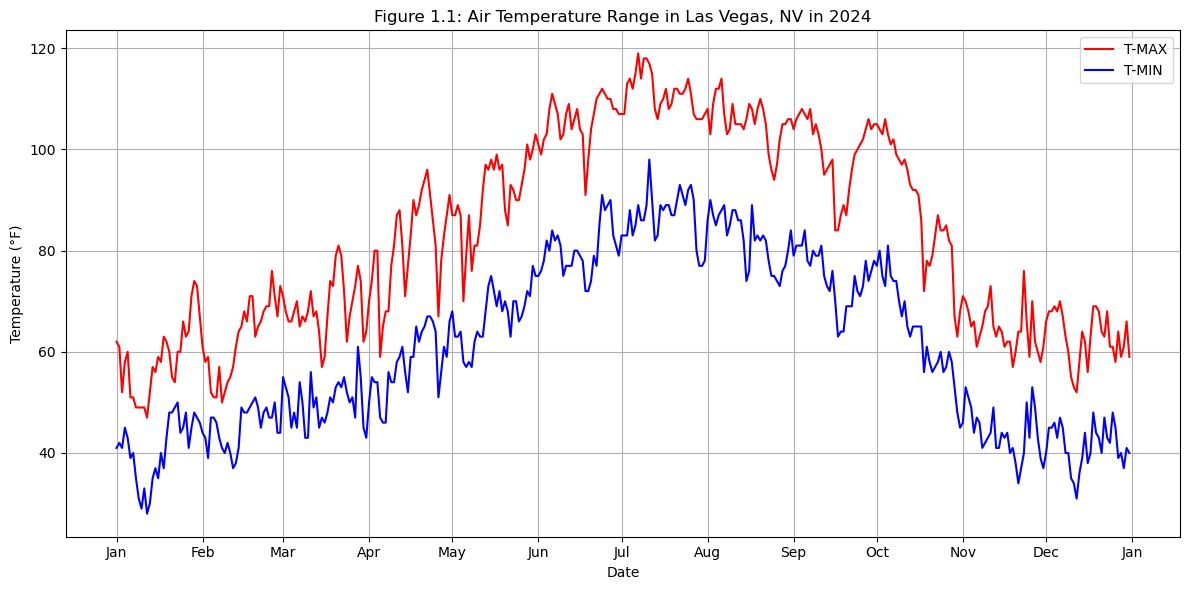

In [13]:
# fig 1.1: plotting daily min and max temps over the year
plt.figure(figsize=(12, 6))

plt.plot(df['date'], df['tmax'], color='red', label='T-MAX')
plt.plot(df['date'], df['tmin'], color='blue', label='T-MIN')

plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.title('Figure 1.1: Air Temperature Range in Las Vegas, NV in 2024')

plt.legend()
plt.grid(True)

# set x-axis major ticks to every month
ax = plt.gca()
# locator for every month
ax.xaxis.set_major_locator(mdates.MonthLocator())
# format tick labels as abbreviated month names
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

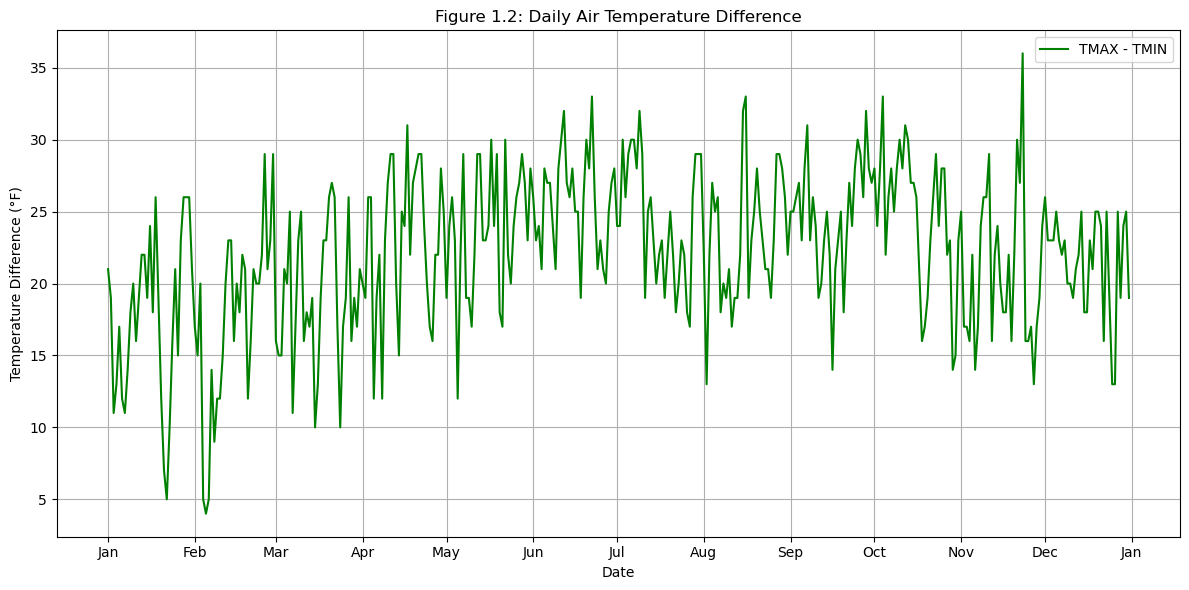

In [14]:
df['tdiff'] = df['tmax'] - df['tmin']

# fig 1.2: showing temp difference over the year
plt.figure(figsize=(12,6))

plt.plot(df.date, df.tdiff, color='green', label='TMAX - TMIN')

plt.xlabel('Date')
plt.ylabel('Temperature Difference (°F)')
plt.title('Figure 1.2: Daily Air Temperature Difference')

plt.legend()
plt.grid(True)
# set x-axis major ticks to every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

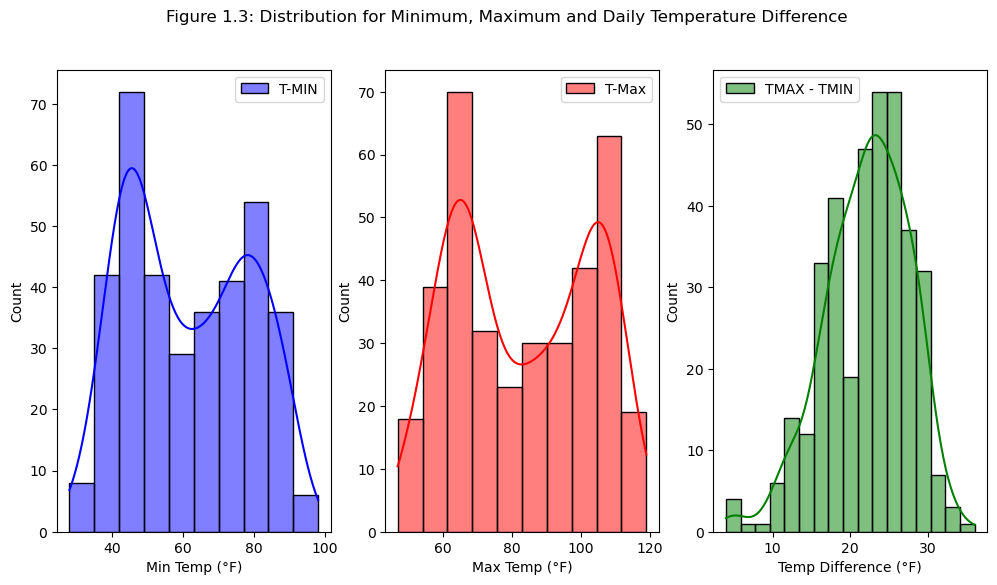

In [25]:
# fig 1.3: distribution of tmin, tmax and (tmax - tmin)
fig, ax = plt.subplots(1, 3, figsize = (12, 6))

sns.histplot(df['tmin'], kde=True, color='blue', ax=ax[0], label='T-MIN')
ax[0].legend()
ax[0].set_xlabel('Min Temp (°F)')

sns.histplot(df['tmax'], kde=True, color='red', ax=ax[1], label='T-Max')
ax[1].legend()
ax[1].set_xlabel('Max Temp (°F)')

sns.histplot(df['tdiff'], kde=True, color='green', ax=ax[2], label='TMAX - TMIN')
ax[2].legend()
ax[2].set_xlabel('Temp Difference (°F)')

fig.suptitle('Figure 1.3: Distribution for Minimum, Maximum and Daily Temperature Difference')
plt.show()

1.1 Findings:

.

.

.



2 Percipitation

In [16]:
# convert 'prcp' from inches to mm for better representation
df['prcp'] = df['prcp'] * 25.4

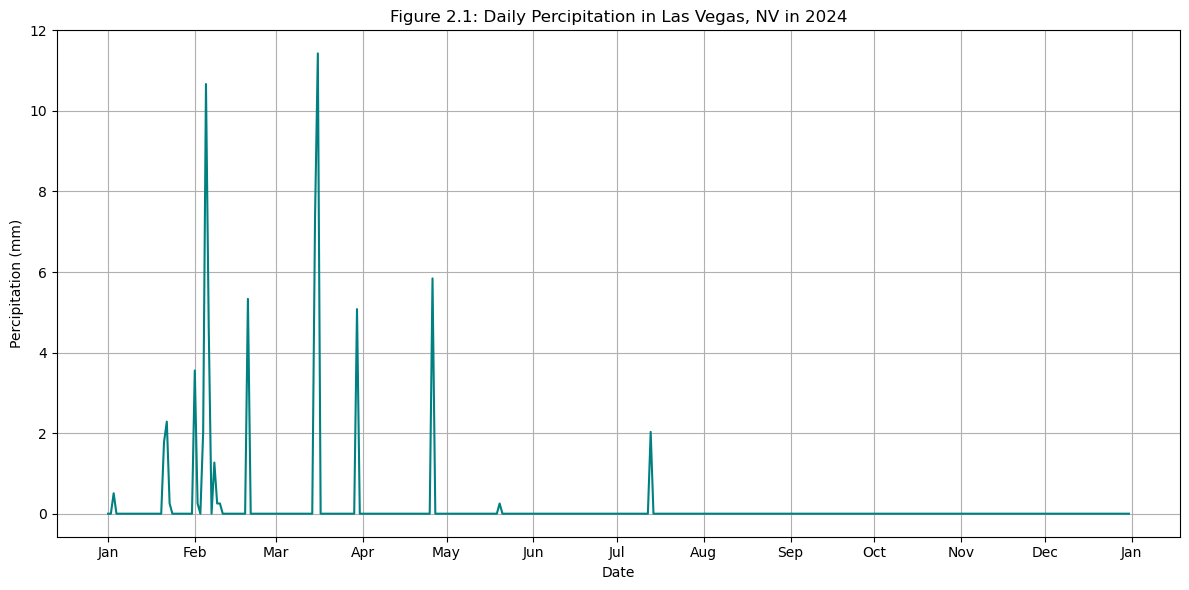

In [17]:
# fig 2.1: plot percipitation over the year
plt.figure(figsize=(12,6))
plt.plot(df.date , df.prcp, color='teal')

plt.xlabel('Date')
plt.ylabel('Percipitation (mm)')
plt.title('Figure 2.1: Daily Percipitation in Las Vegas, NV in 2024')
plt.grid(True)

# set x-axis major ticks to every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

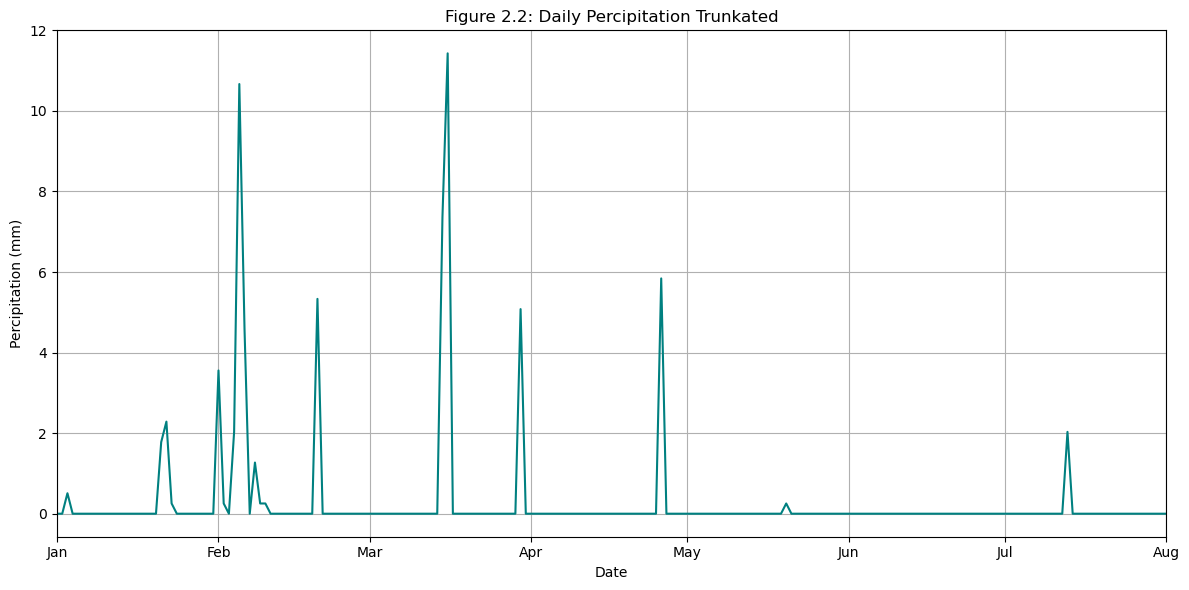

In [18]:
# fig 2.2: plot percipitation up to august
plt.figure(figsize=(12,6))
plt.plot(df.date , df.prcp, color='teal')

plt.xlim(datetime(2024,1,1), datetime(2024,8,1))
plt.xlabel('Date')
plt.ylabel('Percipitation (mm)')
plt.title('Figure 2.2: Daily Percipitation Trunkated')
plt.grid(True)

# set x-axis major ticks to included months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

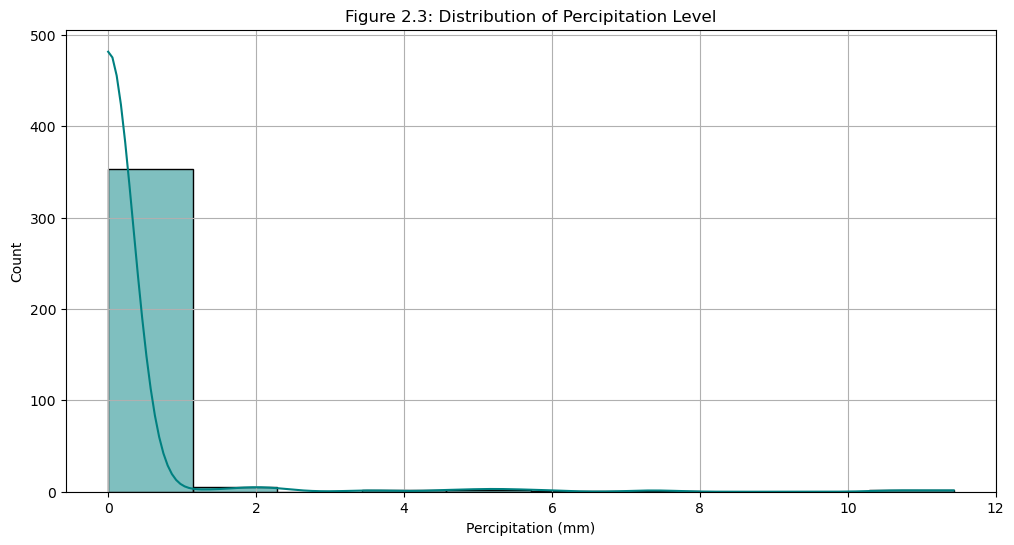

In [19]:
# figure 2.3: plot the distribution of percipitaiton levels
fig = plt.figure(figsize=(12,6))
sns.histplot(df.prcp, kde=True, color='teal')
plt.title('Figure 2.3: Distribution of Percipitation Level')
plt.xlabel('Percipitation (mm)')
plt.grid(True)
plt.show()

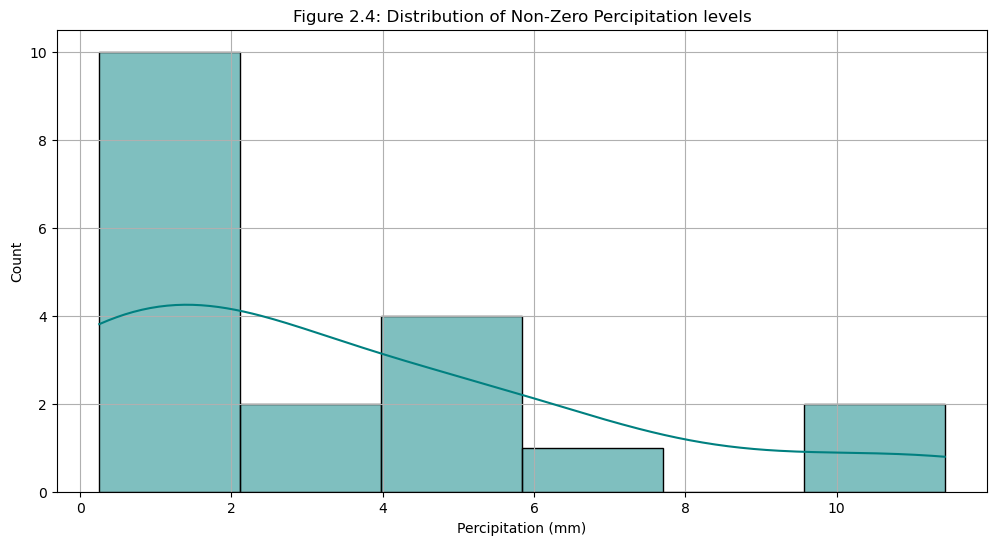

In [20]:
# figure 2.4: plot the distribution of non-zero percipitaiton levels
fig = plt.figure(figsize=(12,6))
sns.histplot(df[df['prcp'] > 0]['prcp'], kde=True, color='teal')
plt.title('Figure 2.4: Distribution of Non-Zero Percipitation levels')
plt.xlabel('Percipitation (mm)')
plt.grid(True)
plt.show()

2 Findings:

.

.

.



3 Ground Water Level

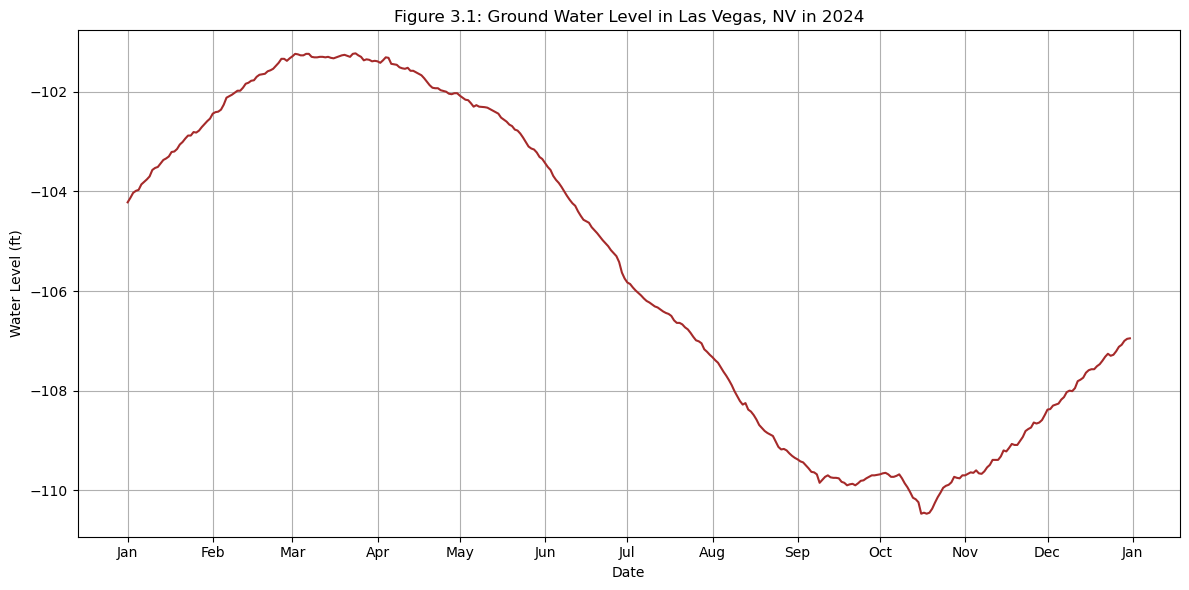

In [29]:
# fig 3.1: plot ground water levels (feet below surface) over the year
plt.figure(figsize=(12,6))
plt.plot(df.date , -df.water_level, color='brown')

plt.xlabel('Date')
plt.ylabel('Water Level (ft)')
plt.title('Figure 3.1: Ground Water Level in Las Vegas, NV in 2024')
plt.grid(True)

# set x-axis major ticks to every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()
plt.show()

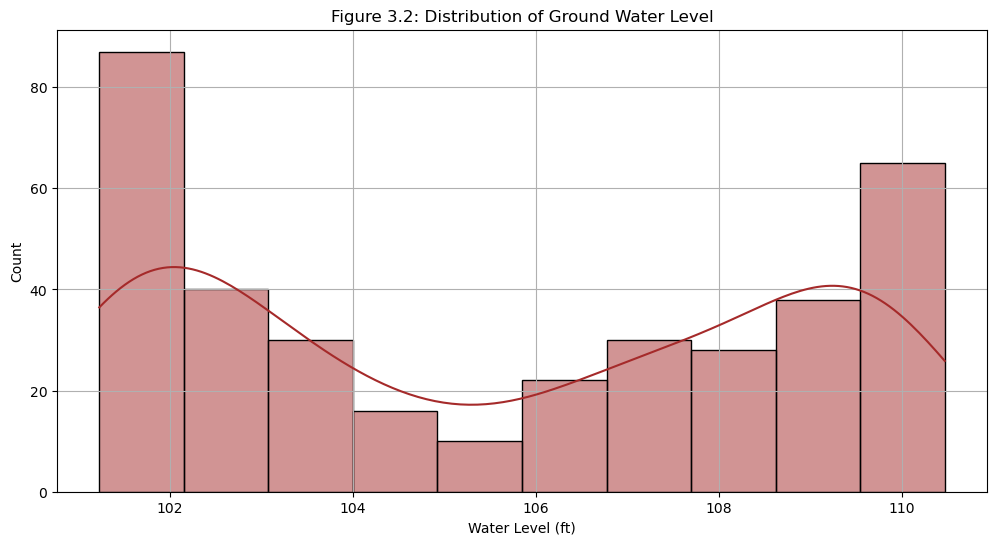

In [28]:
# figure 3.2: plot the distribution of ground water levels
fig = plt.figure(figsize=(12,6))
sns.histplot(df.water_level, kde=True, color='brown')
plt.title('Figure 3.2: Distribution of Ground Water Level')
plt.xlabel('Water Level (ft)')
plt.grid(True)
plt.show()